In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import torch

if torch.cuda.is_available():
    print(f"GPU is enabled. Using device: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not enabled.")

GPU is not enabled.


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
from transformers import AutoFeatureExtractor
import torch
import pandas as pd
import librosa
from tqdm import tqdm  # Import TQDM for progress bar

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the pre-trained feature extractor
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)


Using device: cpu


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [ ]:

# Load your dataset
df = pd.read_csv("/content/processed_targets_output.csv")  # Ensure your dataset contains audio file names, start/end times, and targets

# Prepare audio inputs and labels
audio_inputs = []
targets = []

for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing Audio Files"):  # Add tqdm progress bar
    audio_file = row["audio_file_name"]
    start_time = row["interval_start"]
    end_time = row["interval_end"]
    target = row["next_target"]

    # Load audio segment (10 seconds)
    waveform, sr = librosa.load(
        str('/content/drive/MyDrive/audio_files_22_nov/') + audio_file,

        sr=16000,
        mono=True,
        offset=start_time,
        duration=(end_time - start_time)
    )

    # Use feature extractor
    inputs = feature_extractor(
        waveform,
        sampling_rate=16000,
        return_tensors="pt",
        padding=True
    )

    # Move the extracted features to GPU if available
    input_tensor = inputs["input_values"].to(device)
    audio_inputs.append(input_tensor)
    targets.append(target)

# Stack inputs and targets
audio_inputs = torch.cat(audio_inputs).to(device)  # Move audio_inputs to GPU
targets = torch.tensor(targets, dtype=torch.long).to(device)  # Move targets to GPU

# Save stacked tensors (optional, for later use)
torch.save(audio_inputs, "/content/audio_inputs.pt")
torch.save(targets, "/content/targets.pt")

print("Audio processing complete!")
print(f"audio_inputs shape: {audio_inputs.shape}")
print(f"targets shape: {targets.shape}")

Processing Audio Files: 100%|██████████| 6862/6862 [19:34<00:00,  5.84it/s]


Audio processing complete!
audio_inputs shape: torch.Size([6862, 1024, 128])
targets shape: torch.Size([6862])


In [ ]:
# audio_inputs = torch.load("audio_inputs.pt")
# targets = torch.load("targets.pt")

# print("Loaded audio_inputs shape:", audio_inputs.shape)
# print("Loaded targets shape:", targets.shape)

In [ ]:
import torch
import pandas as pd

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load processed targets file
df = pd.read_csv("processed_targets_output.csv")

# Ensure `audio_inputs` and `df` are aligned
assert len(df) == audio_inputs.size(0), "Mismatch between audio_inputs and processed_targets_output"

# Move `audio_inputs` to the appropriate device
audio_inputs = audio_inputs.to(device)

# Group by audio_file_name
grouped_data = df.groupby("audio_file_name").apply(
    lambda group: {
        "indices": group.index.tolist(),
        "targets": group["next_target"].tolist(),
    }
).to_dict()

# Create compartmentalized data with EOS
compartmentalized_inputs = {}
compartmentalized_targets = {}

for audio_file, data in grouped_data.items():
    indices = data["indices"]
    inputs = audio_inputs[indices]  # Subset audio_inputs tensor
    targets = torch.tensor(data["targets"], dtype=torch.long).to(device)  # Move targets to the same device

    # Add EOS indicator as a new feature
    eos_feature = torch.zeros((inputs.size(0), 1, 1), device=device)  # Shape (time_steps, 1 feature)
    eos_feature[-1] = 1  # EOS is 1 for the last time step of the clip

    # Expand EOS to match feature dimension
    eos_feature = eos_feature.expand(-1, inputs.size(1), 1)

    # Append EOS as an additional feature
    inputs_with_eos = torch.cat((inputs, eos_feature), dim=2)  # Concatenate along feature dimension

    # Add to compartmentalized data
    compartmentalized_inputs[audio_file] = inputs_with_eos
    compartmentalized_targets[audio_file] = targets

# Example: Access inputs and targets for a specific audio file
example_audio_file = list(compartmentalized_inputs.keys())[0]
example_inputs = compartmentalized_inputs[example_audio_file]
example_targets = compartmentalized_targets[example_audio_file]

print(f"Inputs for {example_audio_file}: {example_inputs.shape}")
print(f"Targets for {example_audio_file}: {example_targets.shape}")

Using device: cuda
Inputs for 15 Minutes of Katt Williams.mp3: torch.Size([93, 1024, 129])
Targets for 15 Minutes of Katt Williams.mp3: torch.Size([93])


<ipython-input-11-000efcd0e803>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_data = df.groupby("audio_file_name").apply(


In [ ]:
from sklearn.model_selection import train_test_split
import torch

def split_train_test(compartmentalized_inputs, compartmentalized_targets, test_size=0.2, random_state=42):
    """
    Splits compartmentalized data into train and test sets at the clip level.

    Args:
        compartmentalized_inputs (dict): Dictionary of audio file inputs with EOS indicators.
        compartmentalized_targets (dict): Dictionary of targets corresponding to the inputs.
        test_size (float): Proportion of data to use as test set.
        random_state (int): Random seed for reproducibility.

    Returns:
        X_train, X_test, y_train, y_test: Training and testing data tensors.
    """
    # Get all audio file names (keys)
    all_audio_files = list(compartmentalized_inputs.keys())

    # Split audio file names into train and test
    train_files, test_files = train_test_split(all_audio_files, test_size=test_size, random_state=random_state)

    # Initialize lists for train and test sets
    X_train, y_train, X_test, y_test = [], [], [], []

    # Add data for train files
    for audio_file in train_files:
        X_train.append(compartmentalized_inputs[audio_file])
        y_train.append(compartmentalized_targets[audio_file])

    # Add data for test files
    for audio_file in test_files:
        X_test.append(compartmentalized_inputs[audio_file])
        y_test.append(compartmentalized_targets[audio_file])

    # Concatenate to create train and test tensors
    X_train = torch.cat(X_train, dim=0)  # Combine all training inputs
    y_train = torch.cat(y_train, dim=0)  # Combine all training targets
    X_test = torch.cat(X_test, dim=0)    # Combine all testing inputs
    y_test = torch.cat(y_test, dim=0)    # Combine all testing targets

    return X_train, X_test, y_train, y_test

# Example usage
X_train, X_test, y_train, y_test = split_train_test(compartmentalized_inputs, compartmentalized_targets)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: torch.Size([5016, 1024, 129])
X_test shape: torch.Size([1846, 1024, 129])
y_train shape: torch.Size([5016])
y_test shape: torch.Size([1846])


In [ ]:
#Store train and test data
torch.save(X_train, "X_train.pt")
torch.save(X_test, "X_test.pt")
torch.save(y_train, "y_train.pt")
torch.save(y_test, "y_test.pt")

Using device: cuda
ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTSdpaAttention(
            (attention): ASTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIn

Epoch 1/5 - Validation: 100%|██████████| 58/58 [00:26<00:00,  2.18it/s]


Epoch 1/5 - Training Loss: 0.5985, Validation Loss: 0.5064


Epoch 2/5 - Validation: 100%|██████████| 58/58 [00:26<00:00,  2.18it/s]


Epoch 2/5 - Training Loss: 0.5715, Validation Loss: 0.5146


Epoch 3/5 - Validation: 100%|██████████| 58/58 [00:26<00:00,  2.18it/s]


Epoch 3/5 - Training Loss: 0.5459, Validation Loss: 0.5214


Epoch 4/5 - Validation: 100%|██████████| 58/58 [00:26<00:00,  2.18it/s]


Epoch 4/5 - Training Loss: 0.4925, Validation Loss: 0.5664


Epoch 5/5 - Validation: 100%|██████████| 58/58 [00:26<00:00,  2.18it/s]


Epoch 5/5 - Training Loss: 0.4008, Validation Loss: 0.6367


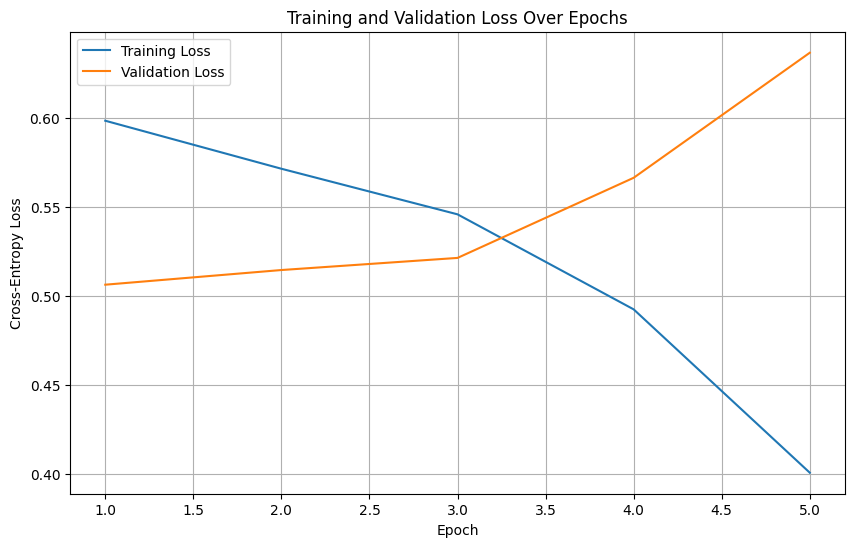

In [ ]:
from transformers import ASTForAudioClassification
from torch import nn
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained AST model
model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
model = ASTForAudioClassification.from_pretrained(model_name)

# # Freeze layers selectively (first 8 layers)
# for name, param in model.named_parameters():
#     # Check if the parameter is within the encoder layers
#     if name.startswith("audio_spectrogram_transformer.encoder.layer"):
#         layer_index = int(name.split('.')[3])  # Extract layer index from the name
#         if layer_index < 8:  # Freeze only the first 8 layers
#             param.requires_grad = False


# Inspect the classifier layer to determine input feature size
# rich_feature_size = model.classifier.dense.in_features  # Access the input size of the classifier

#Replace the classification head with custom layers
model.classifier = nn.Sequential(
    nn.Linear(rich_feature_size, 256),  # Gradual reduction layer
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 64),  # Another reduction layer
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 1),  # Binary classification layer
)

# Print the updated model architecture
print(model)

# Move model to device
model.to(device)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()  # Cross-Entropy Loss (Logits version for numerical stability)

# Create DataLoader for train and test data
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training loop with progress bar
epochs = 5
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Training with progress bar
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training") as train_bar:
        for X_batch, y_batch in train_bar:
            # Move data to device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(X_batch).logits.squeeze()  # Use logits directly
            loss = criterion(outputs, y_batch.float())  # Cross-entropy loss
            running_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update progress bar
            train_bar.set_postfix(loss=loss.item())

    train_losses.append(running_loss / len(train_loader))

    # Validation loop with progress bar
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        with tqdm(test_loader, desc=f"Epoch {epoch + 1}/{epochs} - Validation") as val_bar:
            for X_batch, y_batch in val_bar:
                # Move data to device
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                # Forward pass
                outputs = model(X_batch).logits.squeeze()
                loss = criterion(outputs, y_batch.float())
                val_loss += loss.item()

    val_losses.append(val_loss / len(test_loader))

    print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

In [ ]:

# Evaluate on test data
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # Move data to device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        outputs = torch.sigmoid(model(X_batch).logits).squeeze()  # Add sigmoid for probabilities
        all_preds.extend(outputs.cpu().numpy())
        all_targets.extend(y_batch.cpu().numpy())



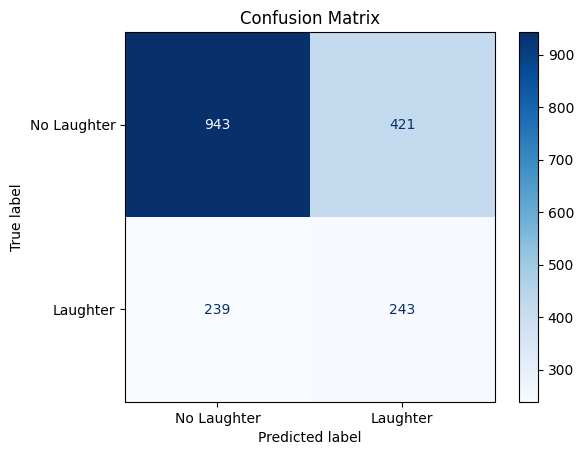

AUC-ROC: 0.6542


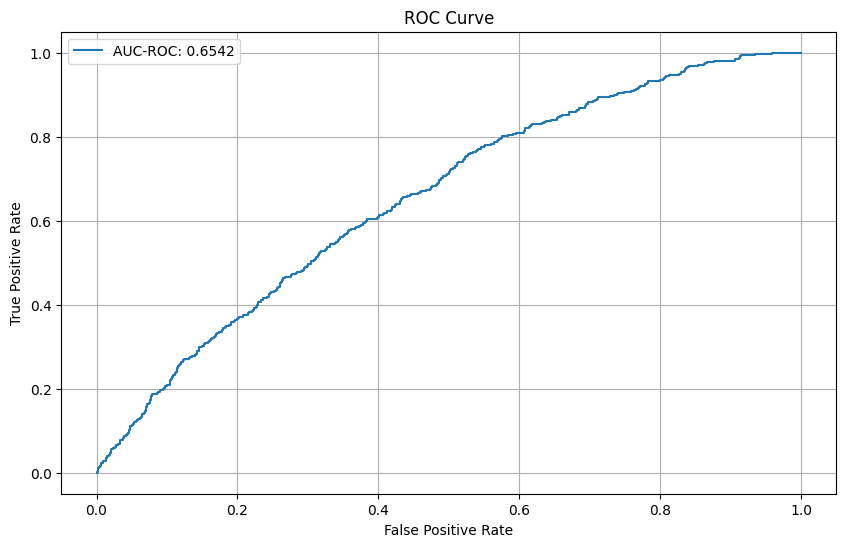

In [ ]:
# Convert predictions to binary
all_preds_binary = (torch.tensor(all_preds) > 0.5).int()

# Confusion matrix
conf_matrix = confusion_matrix(all_targets, all_preds_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No Laughter", "Laughter"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Compute AUC-ROC
auc_roc = roc_auc_score(all_targets, all_preds)
print(f"AUC-ROC: {auc_roc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(all_targets, all_preds)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"AUC-ROC: {auc_roc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()